# Loading the database in Julia

In [1]:
using SQLite
using NPZ
using Images
using Plots

In [2]:
db = SQLite.DB("pix2.sqlite")

SQLite.DB("pix2.sqlite")

In [3]:
res = SQLite.query(db,"select W,pic from static order by random() limit 10") |> DataFrame;

┌ Warning: `SQLite.query(db, sql)` will return an `SQLite.Query` object in the future; to materialize a resultset, do `DataFrame(SQLite.query(db, sql))` instead
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `SQLite.Source(db, sql)` is deprecated in favor of `SQLite.Query(db, sql)` which executes a query and returns a row iterator
│   caller = ip:0x0
└ @ Core :-1


SQLite returns DataFrames that have named fields (but raises a deprecation warning that we have to do it explicitly.)

In [4]:
res

10×2 DataFrame. Omitted printing of 1 columns
│ Row │ W        │
│     │ Float64⍰ │
├─────┼──────────┤
│ 1   │ 0.966294 │
│ 2   │ 1.04197  │
│ 3   │ 1.21328  │
│ 4   │ 0.614656 │
│ 5   │ 0.161352 │
│ 6   │ 1.15319  │
│ 7   │ 1.26725  │
│ 8   │ 0.353509 │
│ 9   │ 0.537248 │
│ 10  │ 0.365611 │

The results are serialized Numpy arrays:

In [5]:
blob1 = res.pic[2];
img = NPZ.npzreadarray(IOBuffer(blob1));

We can use the Images call,

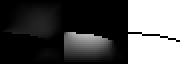

In [22]:
colorview(Gray,hcat([img[:,:,i] for i in 1:3]...))

or the heatmap call to look at them:

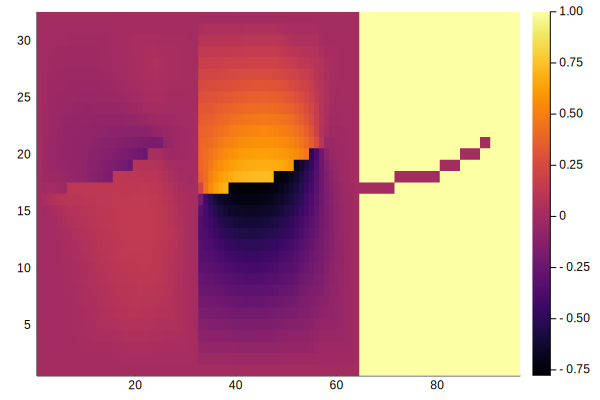

In [7]:
heatmap(hcat([img[:,:,i] for i in 1:3]...))

# Training an autoencoder



In [8]:
using Flux

In [9]:
images_frame = SQLite.query(db,"select pic from static") |> DataFrame;

┌ Warning: `SQLite.query(db, sql)` will return an `SQLite.Query` object in the future; to materialize a resultset, do `DataFrame(SQLite.query(db, sql))` instead
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `SQLite.Source(db, sql)` is deprecated in favor of `SQLite.Query(db, sql)` which executes a query and returns a row iterator
│   caller = ip:0x0
└ @ Core :-1


Read and cat together all of the images into one giant 4D array.

In [10]:
images_array = cat([NPZ.npzreadarray(IOBuffer(blob)) for blob in images_frame.pic]...,dims=4);

In [12]:
size(images_array,4)

1182

In [72]:
size(slices)

(1182,)

In [74]:
map(size,minibatches)

12-element Array{Tuple{Int64,Int64},1}:
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 82) 

In [13]:
slices = [ reshape(images_array[:,:,3,i],(:,)) for i=1:size(images_array,4) ]
minibatches = [ cat(imgs...,dims=2) for imgs in Iterators.partition(slices,100) ]

12-element Array{Array{Float32,2},1}:
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.

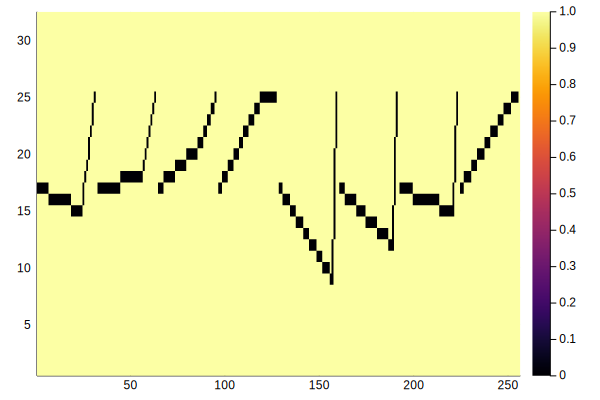

In [14]:
heatmap(hcat([images_array[:,:,3,i] for i in 1175:1182]...))

In [67]:
picw = size(images_array,1)
N_latent = 4
encoder = Dense(picw^2, N_latent, leakyrelu)
decoder = Dense(N_latent, picw^2, leakyrelu)
m = Chain(encoder, decoder)
loss(x) = Flux.mse(m(x),x)

loss (generic function with 1 method)

In [68]:
function side_by_side(x)
    hcat( reshape(x,(32,32) ), reshape(Flux.data(m(x)), (32,32)))
end
function side_by_side_stack(xs)
    vcat([
        hcat( reshape(x,(32,32) ), reshape(Flux.data(m(x)), (32,32)))
            for x in xs ]...
    )
end

side_by_side_stack (generic function with 1 method)

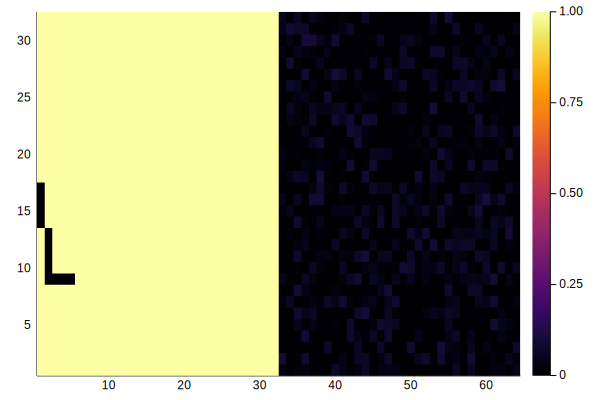

In [69]:
side_by_side( reshape(minibatches[1][:,1], (:,1) ) ) |> heatmap

In [75]:
evalcb = Flux.throttle(() -> @show(loss(minibatches[2])), 1.0)
opt = ADAM()

Flux.@epochs 1e3 Flux.train!(loss, params(m), zip(minibatches), opt, cb = evalcb)

┌ Info: Epoch 1.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.018296802f0 (tracked)


┌ Info: Epoch 2.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 3.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 4.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 5.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 6.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 7.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 8.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 9.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 10.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 11.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 12.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:

loss(minibatches[2]) = 0.009972138f0 (tracked)


┌ Info: Epoch 18.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 19.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 20.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 21.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 22.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 23.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 24.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 25.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 26.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 27.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 28.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/t

loss(minibatches[2]) = 0.00959473f0 (tracked)


┌ Info: Epoch 34.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 35.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 36.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 37.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 38.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 39.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 40.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 41.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 42.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 43.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 44.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/t

loss(minibatches[2]) = 0.00987352f0 (tracked)


┌ Info: Epoch 49.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 50.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 51.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 52.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 53.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 54.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 55.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 56.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 57.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 58.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 59.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/t

loss(minibatches[2]) = 0.009933182f0 (tracked)


┌ Info: Epoch 66.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 67.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 68.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 69.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 70.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 71.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 72.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 73.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 74.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 75.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 76.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/t

loss(minibatches[2]) = 0.010244443f0 (tracked)


┌ Info: Epoch 84.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 85.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 86.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 87.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 88.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 89.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 90.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 91.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 92.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 93.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 94.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/t

loss(minibatches[2]) = 0.010288763f0 (tracked)


┌ Info: Epoch 97.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 98.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 99.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 100.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 101.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 102.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 103.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 104.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 105.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 106.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 107.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/op

loss(minibatches[2]) = 0.010098564f0 (tracked)


┌ Info: Epoch 113.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 114.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 115.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 116.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 117.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 118.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 119.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 120.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 121.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 122.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 123.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009602325f0 (tracked)


┌ Info: Epoch 125.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 126.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 127.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 128.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 129.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 130.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 131.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 132.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 133.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 134.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 135.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009584861f0 (tracked)


┌ Info: Epoch 141.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 142.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 143.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 144.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 145.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 146.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 147.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 148.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 149.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 150.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 151.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009920282f0 (tracked)


┌ Info: Epoch 156.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 157.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 158.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 159.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 160.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 161.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 162.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 163.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 164.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 165.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 166.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009710763f0 (tracked)


┌ Info: Epoch 168.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 169.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 170.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 171.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 172.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 173.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 174.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 175.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 176.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 177.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 178.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010074639f0 (tracked)


┌ Info: Epoch 183.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 184.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 185.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 186.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 187.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 188.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 189.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 190.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 191.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 192.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 193.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009994649f0 (tracked)


┌ Info: Epoch 199.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 200.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 201.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 202.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 203.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 204.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 205.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 206.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 207.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 208.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 209.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.011053276f0 (tracked)


┌ Info: Epoch 215.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 216.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 217.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 218.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 219.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 220.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 221.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 222.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 223.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 224.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 225.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009521711f0 (tracked)


┌ Info: Epoch 230.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 231.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 232.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 233.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 234.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 235.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 236.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 237.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 238.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 239.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 240.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.015102609f0 (tracked)


┌ Info: Epoch 243.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 244.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 245.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 246.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 247.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 248.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 249.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 250.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 251.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 252.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 253.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010802261f0 (tracked)


┌ Info: Epoch 254.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 255.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 256.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 257.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 258.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 259.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 260.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 261.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 262.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 263.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 264.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009827777f0 (tracked)


┌ Info: Epoch 270.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 271.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 272.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 273.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 274.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 275.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 276.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 277.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 278.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 279.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 280.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009532415f0 (tracked)


┌ Info: Epoch 282.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 283.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 284.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 285.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 286.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 287.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 288.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 289.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 290.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 291.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 292.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009585647f0 (tracked)


┌ Info: Epoch 297.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 298.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 299.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 300.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 301.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 302.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 303.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 304.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 305.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 306.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 307.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009800981f0 (tracked)


┌ Info: Epoch 314.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 315.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 316.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 317.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 318.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 319.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 320.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 321.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 322.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 323.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.009263432f0 (tracked)


┌ Info: Epoch 324.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 325.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 326.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 327.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 328.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 329.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 330.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 331.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 332.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 333.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 334.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.0094497055f0 (tracked)


┌ Info: Epoch 336.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 337.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 338.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 339.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 340.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 341.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 342.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 343.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 344.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 345.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 346.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009800661f0 (tracked)


┌ Info: Epoch 348.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 349.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 350.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 351.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 352.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 353.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 354.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 355.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.009688525f0 (tracked)


┌ Info: Epoch 356.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 357.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 358.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 359.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 360.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 361.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 362.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 363.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 364.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 365.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 366.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009582615f0 (tracked)


┌ Info: Epoch 369.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 370.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 371.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 372.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 373.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 374.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 375.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 376.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 377.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 378.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 379.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009263172f0 (tracked)


┌ Info: Epoch 380.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 381.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 382.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 383.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 384.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 385.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 386.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 387.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 388.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 389.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 390.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009644452f0 (tracked)


┌ Info: Epoch 392.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 393.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 394.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 395.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 396.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 397.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 398.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 399.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 400.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 401.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 402.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009290001f0 (tracked)


┌ Info: Epoch 405.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 406.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 407.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 408.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 409.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 410.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 411.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 412.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 413.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 414.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 415.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009665268f0 (tracked)


┌ Info: Epoch 419.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 420.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 421.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 422.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 423.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 424.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 425.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 426.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 427.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 428.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 429.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009616858f0 (tracked)


┌ Info: Epoch 431.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 432.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 433.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 434.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 435.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 436.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 437.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 438.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 439.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.009640106f0 (tracked)


┌ Info: Epoch 440.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 441.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 442.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 443.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 444.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 445.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 446.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 447.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 448.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 449.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.009263483f0 (tracked)


┌ Info: Epoch 450.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 451.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 452.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 453.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 454.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 455.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 456.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 457.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 458.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 459.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 460.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009706618f0 (tracked)


┌ Info: Epoch 463.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 464.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 465.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 466.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 467.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 468.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 469.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 470.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 471.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 472.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 473.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009593266f0 (tracked)


┌ Info: Epoch 474.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 475.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 476.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 477.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 478.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 479.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 480.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 481.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 482.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 483.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 484.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009848271f0 (tracked)


┌ Info: Epoch 486.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 487.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 488.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 489.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 490.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 491.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 492.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 493.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 494.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 495.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 496.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009944066f0 (tracked)


┌ Info: Epoch 501.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 502.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 503.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 504.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 505.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 506.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 507.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 508.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 509.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 510.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 511.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009582295f0 (tracked)


┌ Info: Epoch 514.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 515.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 516.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 517.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 518.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 519.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 520.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 521.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 522.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 523.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 524.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009535257f0 (tracked)


┌ Info: Epoch 525.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 526.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 527.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 528.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 529.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 530.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 531.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 532.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 533.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 534.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.009918047f0 (tracked)


┌ Info: Epoch 535.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 536.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 537.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 538.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 539.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 540.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 541.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 542.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 543.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 544.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 545.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009505824f0 (tracked)


┌ Info: Epoch 548.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 549.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 550.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 551.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 552.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 553.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 554.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 555.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 556.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 557.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 558.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.01213638f0 (tracked)


┌ Info: Epoch 562.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 563.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 564.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 565.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 566.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 567.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 568.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 569.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 570.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 571.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 572.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009344727f0 (tracked)


┌ Info: Epoch 577.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 578.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 579.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 580.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 581.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 582.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 583.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 584.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 585.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 586.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 587.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009480879f0 (tracked)


┌ Info: Epoch 592.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 593.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 594.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 595.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 596.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 597.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 598.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 599.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 600.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 601.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 602.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010028091f0 (tracked)


┌ Info: Epoch 607.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 608.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 609.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 610.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 611.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 612.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 613.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 614.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 615.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 616.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 617.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.00970048f0 (tracked)


┌ Info: Epoch 622.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 623.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 624.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 625.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 626.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 627.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 628.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 629.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 630.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 631.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 632.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009612781f0 (tracked)


┌ Info: Epoch 637.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 638.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 639.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 640.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 641.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 642.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 643.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 644.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 645.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 646.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 647.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009435467f0 (tracked)


┌ Info: Epoch 652.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 653.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 654.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 655.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 656.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 657.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 658.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 659.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 660.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 661.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 662.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009803842f0 (tracked)


┌ Info: Epoch 668.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 669.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 670.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 671.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 672.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 673.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 674.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 675.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 676.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 677.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 678.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.00905341f0 (tracked)


┌ Info: Epoch 683.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 684.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 685.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 686.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 687.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 688.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 689.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 690.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 691.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 692.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 693.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010939319f0 (tracked)


┌ Info: Epoch 698.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 699.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 700.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 701.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 702.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 703.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 704.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 705.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 706.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 707.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 708.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010947685f0 (tracked)


┌ Info: Epoch 711.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 712.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 713.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 714.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 715.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 716.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 717.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 718.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 719.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 720.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 721.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010679669f0 (tracked)


┌ Info: Epoch 724.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 725.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 726.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 727.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 728.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 729.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 730.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 731.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 732.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 733.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 734.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009069231f0 (tracked)


┌ Info: Epoch 742.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 743.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 744.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 745.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 746.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 747.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 748.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 749.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 750.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 751.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 752.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.011416733f0 (tracked)


┌ Info: Epoch 761.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 762.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 763.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 764.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 765.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 766.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 767.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 768.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 769.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 770.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 771.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009744557f0 (tracked)


┌ Info: Epoch 776.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 777.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 778.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 779.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 780.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 781.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 782.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 783.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 784.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 785.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 786.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.011555521f0 (tracked)


┌ Info: Epoch 790.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 791.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 792.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 793.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 794.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 795.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 796.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 797.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 798.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 799.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 800.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.01158843f0 (tracked)


┌ Info: Epoch 805.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 806.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 807.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 808.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 809.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 810.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 811.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 812.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 813.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 814.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 815.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009131609f0 (tracked)


┌ Info: Epoch 821.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 822.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 823.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 824.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 825.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 826.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 827.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 828.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 829.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 830.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 831.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.0103253005f0 (tracked)


┌ Info: Epoch 837.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 838.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 839.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 840.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 841.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 842.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 843.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 844.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 845.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 846.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 847.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.012556898f0 (tracked)


┌ Info: Epoch 854.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 855.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 856.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 857.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 858.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 859.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 860.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 861.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 862.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 863.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 864.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010956681f0 (tracked)


┌ Info: Epoch 870.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 871.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 872.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 873.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 874.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 875.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 876.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 877.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 878.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 879.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 880.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.012294738f0 (tracked)


┌ Info: Epoch 887.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 888.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 889.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 890.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 891.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 892.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 893.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 894.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 895.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 896.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 897.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.011701827f0 (tracked)


┌ Info: Epoch 903.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 904.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 905.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 906.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 907.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 908.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 909.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 910.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 911.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 912.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 913.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.011945281f0 (tracked)


┌ Info: Epoch 919.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 920.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 921.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 922.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 923.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 924.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 925.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 926.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 927.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 928.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 929.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010822289f0 (tracked)


┌ Info: Epoch 935.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 936.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 937.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 938.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 939.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 940.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 941.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 942.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 943.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 944.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 945.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.014696538f0 (tracked)


┌ Info: Epoch 952.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 953.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 954.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 955.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 956.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 957.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 958.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 959.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 960.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 961.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 962.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009019789f0 (tracked)


┌ Info: Epoch 967.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 968.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 969.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 970.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 971.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 972.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 973.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 974.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 975.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 976.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 977.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.010046688f0 (tracked)


┌ Info: Epoch 983.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 984.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 985.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 986.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 987.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 988.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 989.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 990.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 991.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 992.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 993.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src

loss(minibatches[2]) = 0.009242452f0 (tracked)


┌ Info: Epoch 998.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 999.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 1000.0
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


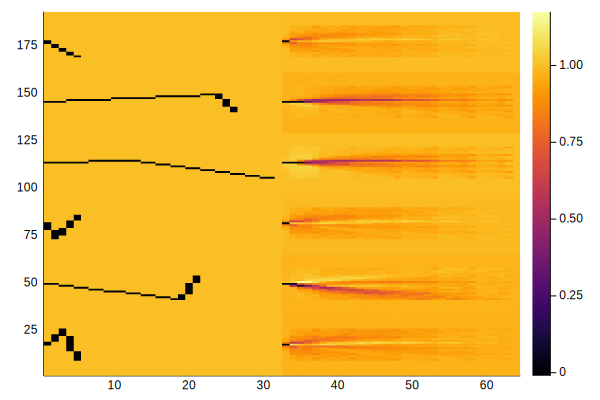

In [85]:
side_by_side_stack([ reshape(slices[i], (:,1) ) 
        for i in rand(1:size(slices,1),(6,)) ]) |> heatmap
